# [E-10] 인물사진 만들기

## 1. 인물모드 직접 해보기

> * 최소 3장 이상의 인물모드 사진을 만들어 본다.
>* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있다. 시맨틱 세그멘테이션 스텝에서 힌트가 있다.
> * 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 본다. 

### 1-1. 사용할 패키지 불러오기

$ pip install opencv-python

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 1-2. 사용할 이미지 확인하기

In [2]:
import os
img_path01 = os.getenv('HOME')+'/aiffel/human_segmentation/images/suzy02.jpg'   
img_orig01 = cv2.imread(img_path01) 
print (img_orig01.shape)

(667, 613, 3)


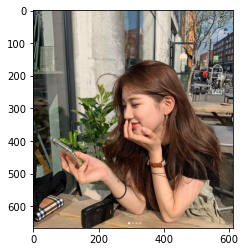

In [3]:
img_orig01 = cv2.cvtColor(img_orig01, cv2.COLOR_BGR2RGB)     
plt.imshow(img_orig01)      # 사용할 이미지   01
plt.show()

In [4]:
img_path02 = os.getenv('HOME')+'/aiffel/human_segmentation/images/suzy03.jpg'  
img_orig02 = cv2.imread(img_path02) 
print (img_orig02.shape)

(665, 639, 3)


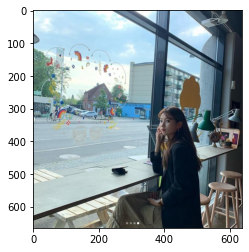

In [5]:
img_orig02 = cv2.cvtColor(img_orig02, cv2.COLOR_BGR2RGB)     
plt.imshow(img_orig02)      # 사용할 이미지   02
plt.show()

In [6]:
img_path03 = os.getenv('HOME')+'/aiffel/human_segmentation/images/mycat01.jpeg'  
img_orig03 = cv2.imread(img_path03) 
print (img_orig03.shape)

(687, 810, 3)


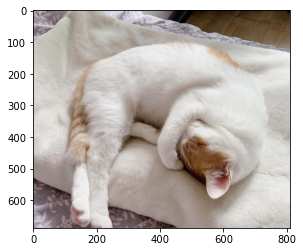

In [7]:
img_orig03 = cv2.cvtColor(img_orig03, cv2.COLOR_BGR2RGB)     
plt.imshow(img_orig03)      # 사용할 이미지   03
plt.show()

In [8]:
img_path04 = os.getenv('HOME')+'/aiffel/human_segmentation/images/mycat02.jpeg'  
img_orig04 = cv2.imread(img_path04) 
print (img_orig04.shape)

(709, 810, 3)


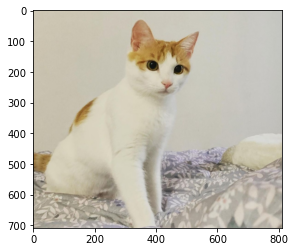

In [9]:
img_orig04 = cv2.cvtColor(img_orig04, cv2.COLOR_BGR2RGB)     
plt.imshow(img_orig04)      # 사용할 이미지   04
plt.show()

### 1-3. 이미지 세그멘테이션

In [10]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
      
print("끝")

끝


In [11]:
# 사전에 학습된 가중치 다운로드

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)         # 모델 정의
print('model loaded successfully!')

temp directory: /home/aiffel-dj23/aiffel/human_segmentation/models
model loaded successfully!


In [12]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [13]:
img_resized, seg_map = MODEL.run(img_orig01)
print (img_orig01.shape, img_resized.shape, seg_map.max())

(667, 613, 3) (513, 471, 3) 16


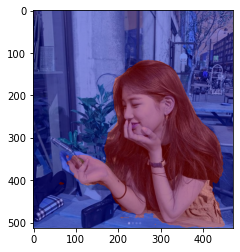

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출, 나머지는 0
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show01 = cv2.addWeighted(img_show, 0.6, color_mask, 0.6, 0.0)

plt.imshow(cv2.cvtColor(img_show01, cv2.COLOR_BGR2RGB))
plt.show()

### 1-4. 세그멘테이션 결과 복원하기

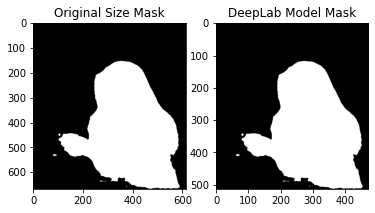

In [15]:
img_mask_up = cv2.resize(img_mask, img_orig01.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)   # 리사이즈
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### 배경 흐리게 하기

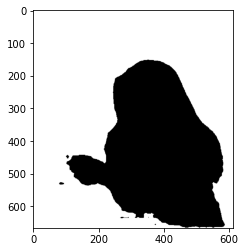

In [16]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 이미지 반전, 배경 255 사람 0(b)
plt.imshow(img_bg_mask)
plt.show()

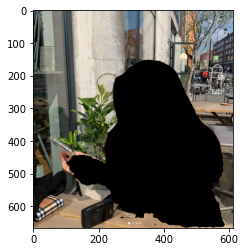

In [17]:
img_bg01 = cv2.bitwise_and(img_orig01, img_bg_mask)   # bitwise_and 배경만 있는 영상
plt.imshow(img_bg01)
plt.show()

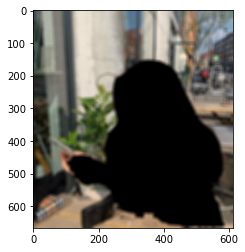

In [18]:
img_bg_blur01 = cv2.blur(img_bg01, (13,13))               # 배경만 있는 사진 블러 처리
plt.imshow(img_bg_blur01)
plt.show()

#### 흐린 배경과 원본 사진 합성

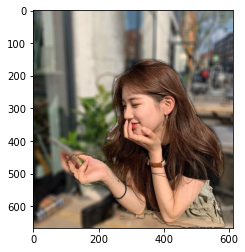

In [19]:
img_concat01 = np.where(img_mask_color==255, img_orig01, img_bg_blur01)  # segmentation mask가 255인 부분만 블러처리 이미지
plt.imshow(img_concat01)
plt.show()

#### 사진 저장하기

In [70]:
result01 = cv2.cvtColor(img_concat01, cv2.COLOR_BGR2RGB)  
cv2.imwrite('result01.jpg', result01)

True

### 그림 02

In [20]:
img_resized, seg_map = MODEL.run(img_orig02)
print (img_orig02.shape, img_resized.shape, seg_map.max())

(665, 639, 3) (513, 492, 3) 15


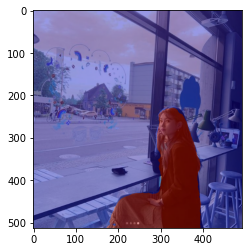

In [21]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출, 나머지는 0
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show02 = cv2.addWeighted(img_show, 0.6, color_mask, 0.6, 0.0)

plt.imshow(cv2.cvtColor(img_show02, cv2.COLOR_BGR2RGB))
plt.show()

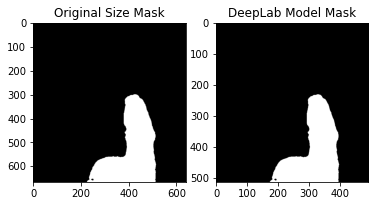

In [22]:
img_mask_up = cv2.resize(img_mask, img_orig02.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)   # 리사이즈
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

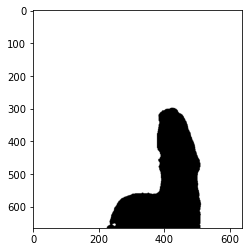

In [23]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)    # bitwise_not 이미지 반전, 배경 255 사람 0(b)
plt.imshow(img_bg_mask)
plt.show()

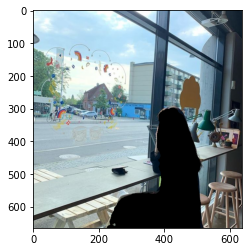

In [24]:
img_bg02 = cv2.bitwise_and(img_orig02, img_bg_mask)   # bitwise_and 배경만 있는 영상
plt.imshow(img_bg02)
plt.show()

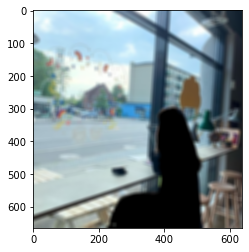

In [25]:
img_bg_blur02 = cv2.blur(img_bg02, (13,13))               # 배경만 있는 사진 블러 처리
plt.imshow(img_bg_blur02)
plt.show()

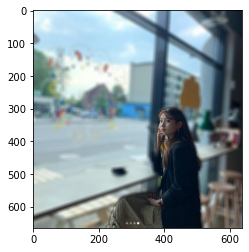

In [26]:
img_concat02 = np.where(img_mask_color==255, img_orig02, img_bg_blur02)  # segmentation mask가 255인 부분만 블러처리 이미지
plt.imshow(img_concat02)
plt.show()

#### 사진 저장하기

In [71]:
result02 = cv2.cvtColor(img_concat02, cv2.COLOR_BGR2RGB)  
cv2.imwrite('result02.jpg', result02)

True

### 그림 03

In [27]:
img_resized, seg_map = MODEL.run(img_orig03)
print (img_orig03.shape, img_resized.shape, seg_map.max())

(687, 810, 3) (435, 513, 3) 8


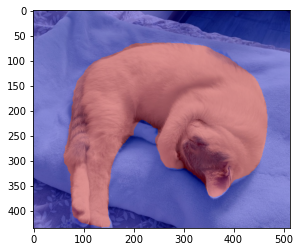

In [28]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출, 나머지는 0
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show03 = cv2.addWeighted(img_show, 0.6, color_mask, 0.6, 0.0)

plt.imshow(cv2.cvtColor(img_show03, cv2.COLOR_BGR2RGB))
plt.show()

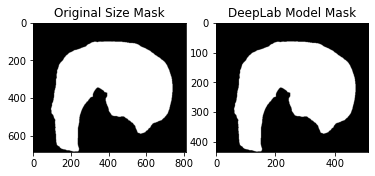

In [29]:
img_mask_up = cv2.resize(img_mask, img_orig03.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)   # 리사이즈
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

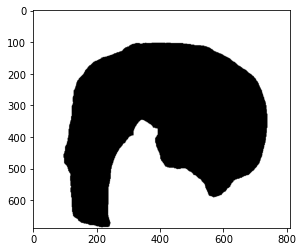

In [30]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask03 = cv2.bitwise_not(img_mask_color)    # bitwise_not 이미지 반전, 배경 255 고양이 0(b)
plt.imshow(img_bg_mask03)
plt.show()

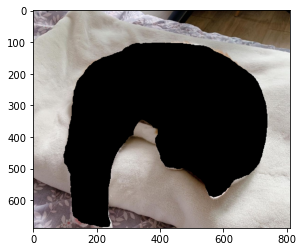

In [31]:
img_bg03 = cv2.bitwise_and(img_orig03, img_bg_mask03)   # bitwise_and 배경만 있는 영상
plt.imshow(img_bg03)
plt.show()

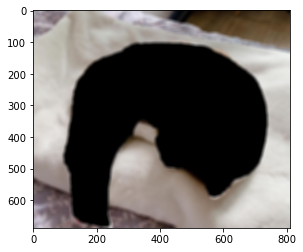

In [32]:
img_bg_blur03 = cv2.blur(img_bg03, (13,13))               # 배경만 있는 사진 블러 처리
plt.imshow(img_bg_blur03)
plt.show()

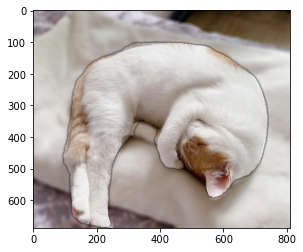

In [33]:
img_concat03 = np.where(img_mask_color== 255, img_orig03, img_bg_blur03)  # segmentation mask가 255인 부분은 배경
plt.imshow(img_concat03)
plt.show()

#### 사진 저장하기

In [72]:
result03 = cv2.cvtColor(img_concat03, cv2.COLOR_BGR2RGB)  
cv2.imwrite('result03.jpg', result03)

True

### 배경 전환하기

In [34]:
bg01 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg04.jpg'   
bg01 = cv2.imread(bg01) 
print (bg01.shape)

(635, 960, 3)


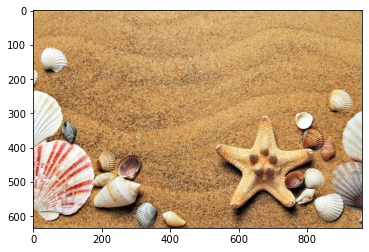

In [35]:
bg_orig01 = cv2.cvtColor(bg01, cv2.COLOR_BGR2RGB)     
plt.imshow(bg_orig01)   
plt.show()

In [36]:
import os
import numpy as np
import cv2
from PIL import Image

img_array = np.array(bg_orig01)
img_resize = cv2.resize(img_array, (810, 687), interpolation = cv2.INTER_AREA)   # 크기 조정하기
bg01 = Image.fromarray(img_resize)

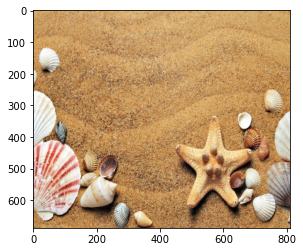

In [37]:
plt.imshow(bg01)   
plt.show()

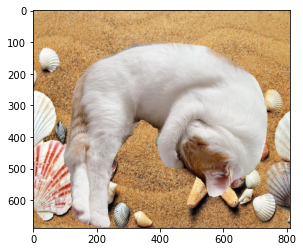

In [38]:
bg_concat03 = np.where(img_mask_color==0, bg01,img_orig03)  # 배경과 이미지 합치기
plt.imshow(bg_concat03)
plt.show()

#### 사진 저장하기

In [74]:
result05 = cv2.cvtColor(bg_concat03, cv2.COLOR_BGR2RGB)  
cv2.imwrite('result05.jpg', result05)

True

### 그림 4

In [39]:
img_resized, seg_map = MODEL.run(img_orig04)
print (img_orig04.shape, img_resized.shape, seg_map.max())

(709, 810, 3) (449, 513, 3) 8


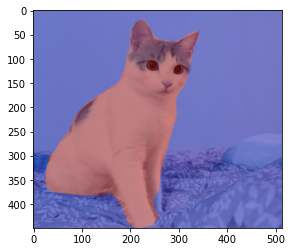

In [40]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출, 나머지는 0
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show04 = cv2.addWeighted(img_show, 0.6, color_mask, 0.6, 0.0)

plt.imshow(cv2.cvtColor(img_show04, cv2.COLOR_BGR2RGB))
plt.show()

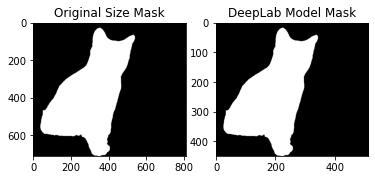

In [41]:
img_mask_up = cv2.resize(img_mask, img_orig04.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)   # 리사이즈
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

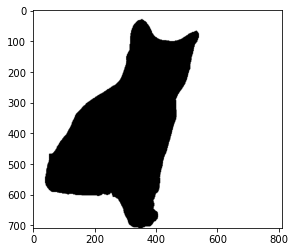

In [42]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask04 = cv2.bitwise_not(img_mask_color)    # bitwise_not 이미지 반전, 배경 255 사람 0(b)
plt.imshow(img_bg_mask04)
plt.show()

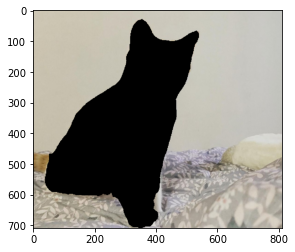

In [43]:
img_bg04 = cv2.bitwise_and(img_orig04, img_bg_mask04)   # bitwise_and 배경만 있는 영상
plt.imshow(img_bg04)
plt.show()

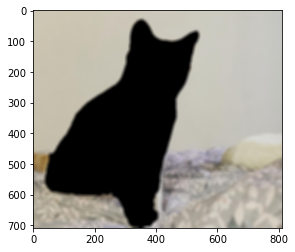

In [44]:
img_bg_blur04 = cv2.blur(img_bg04, (13,13))               # 배경만 있는 사진 블러 처리
plt.imshow(img_bg_blur04)
plt.show()

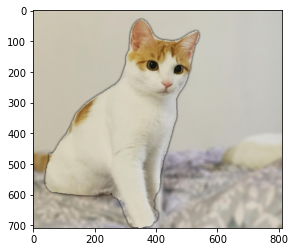

In [46]:
img_concat04 = np.where(img_mask_color== 255, img_orig04, img_bg_blur04)  # segmentation mask가 255인 부분은 배경
plt.imshow(img_concat04)
plt.show()

#### 사진 저장하기

In [76]:
result04 = cv2.cvtColor(img_concat04, cv2.COLOR_BGR2RGB)  
cv2.imwrite('result04.jpg', result04)

True

### 배경 전환하기

In [63]:
bg02 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg06.jpeg'   
bg02 = cv2.imread(bg02) 
print (bg02.shape)

(393, 700, 3)


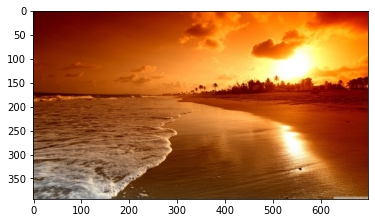

In [64]:
bg_orig02 = cv2.cvtColor(bg02, cv2.COLOR_BGR2RGB)     
plt.imshow(bg_orig02)   
plt.show()

In [65]:
import os
import numpy as np
import cv2
from PIL import Image

img_array = np.array(bg_orig02)
img_resize = cv2.resize(img_array, (810, 709), interpolation = cv2.INTER_AREA)   # 크기 조정하기
bg02 = Image.fromarray(img_resize)

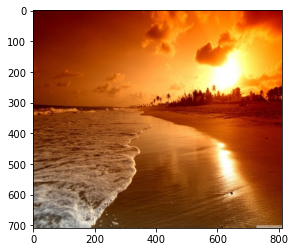

In [66]:
plt.imshow(bg02)   
plt.show()

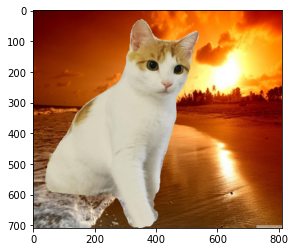

In [67]:
bg_concat04 = np.where(img_mask_color==0, bg02, img_orig04)  # 배경과 이미지 합치기
plt.imshow(bg_concat04)
plt.show()

#### 사진 저장하기

In [75]:
result06 = cv2.cvtColor(bg_concat04, cv2.COLOR_BGR2RGB)  
cv2.imwrite('result06.jpg', result06)

True

## 2. 사진에서 문제점 찾기

> * 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 표시하고, 표시한 이미지들을 jupyter notebook에 포함하여 제출한다.

pip install IPython

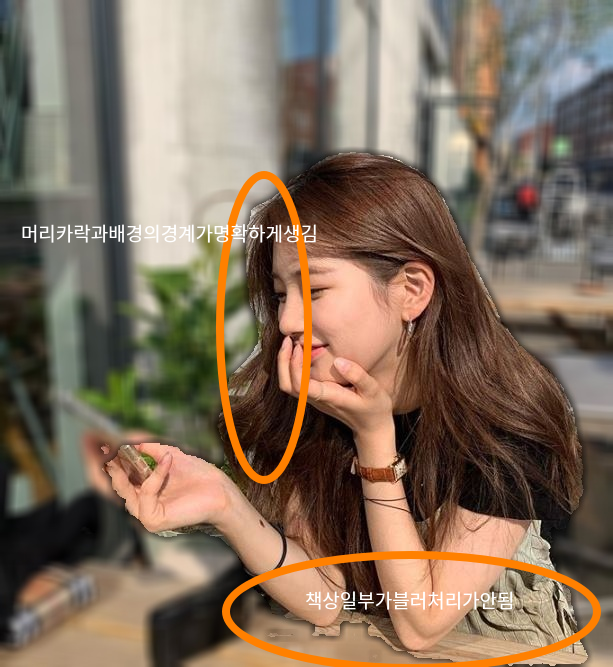

In [77]:
from IPython.display import Image
result_01 = os.getenv('HOME')+'/aiffel/human_segmentation/result/result01.png' 
Image(result_01)

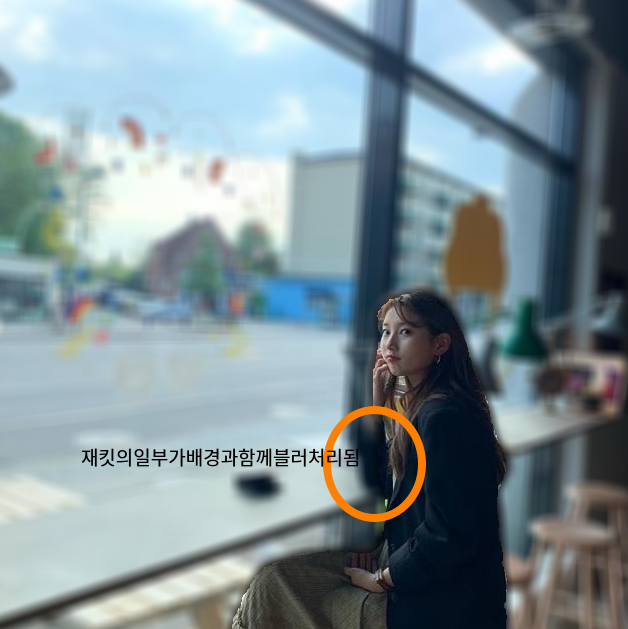

In [78]:
result_02 = os.getenv('HOME')+'/aiffel/human_segmentation/result/result02.png' 
Image(result_02)

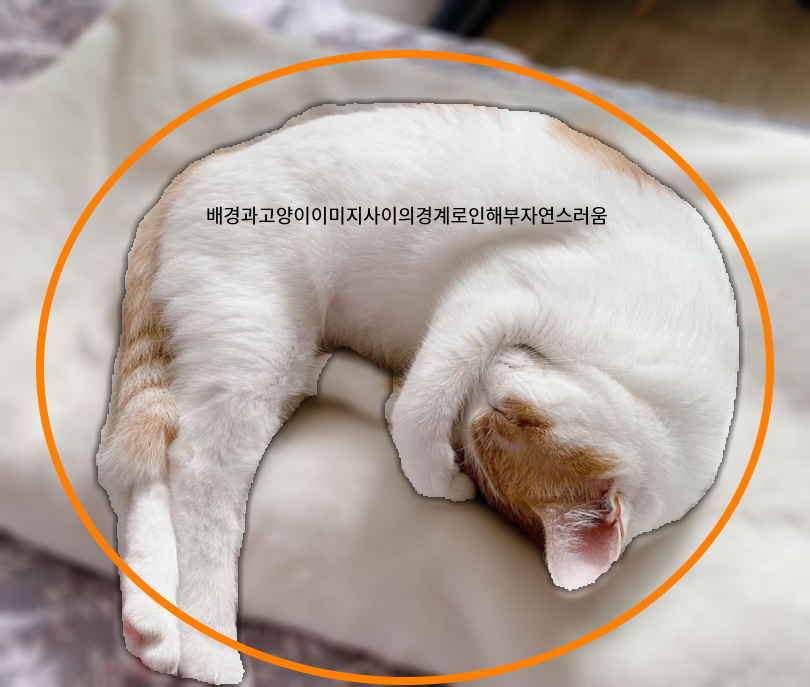

In [79]:
result_03 = os.getenv('HOME')+'/aiffel/human_segmentation/result/result03.png' 
Image(result_03)

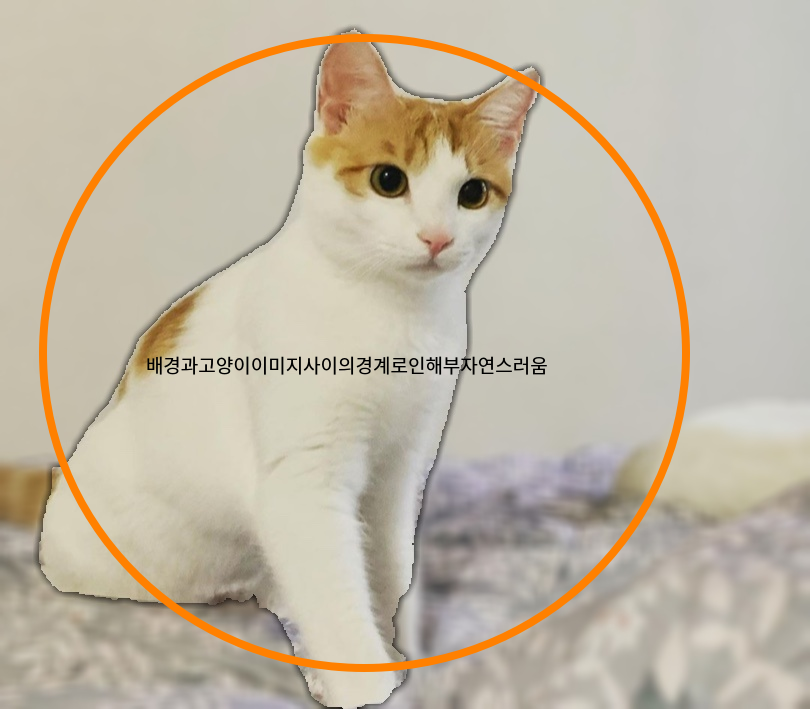

In [80]:
result_04 = os.getenv('HOME')+'/aiffel/human_segmentation/result/result04.png' 
Image(result_04)

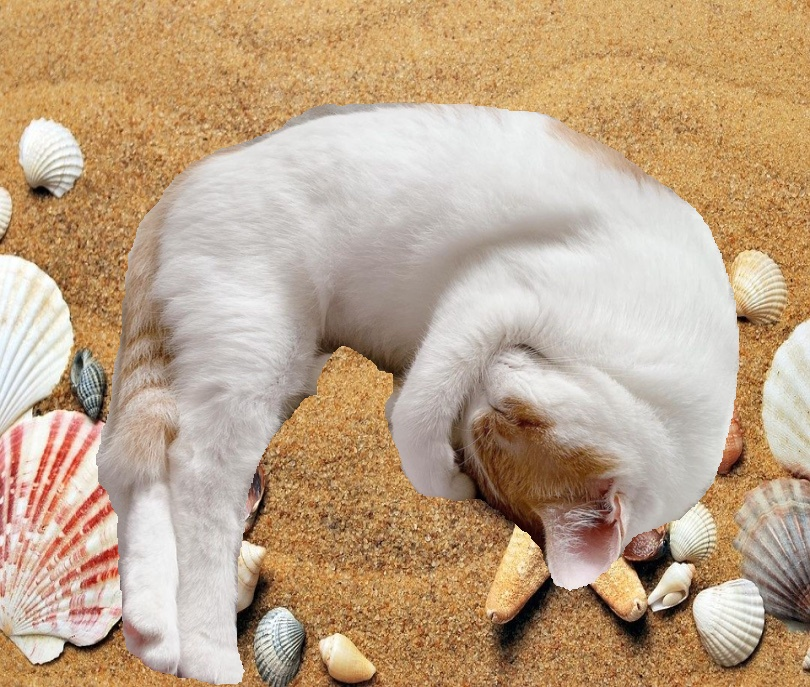

In [81]:
result_05 = os.getenv('HOME')+'/aiffel/human_segmentation/result/result05.jpg' 
Image(result_05)

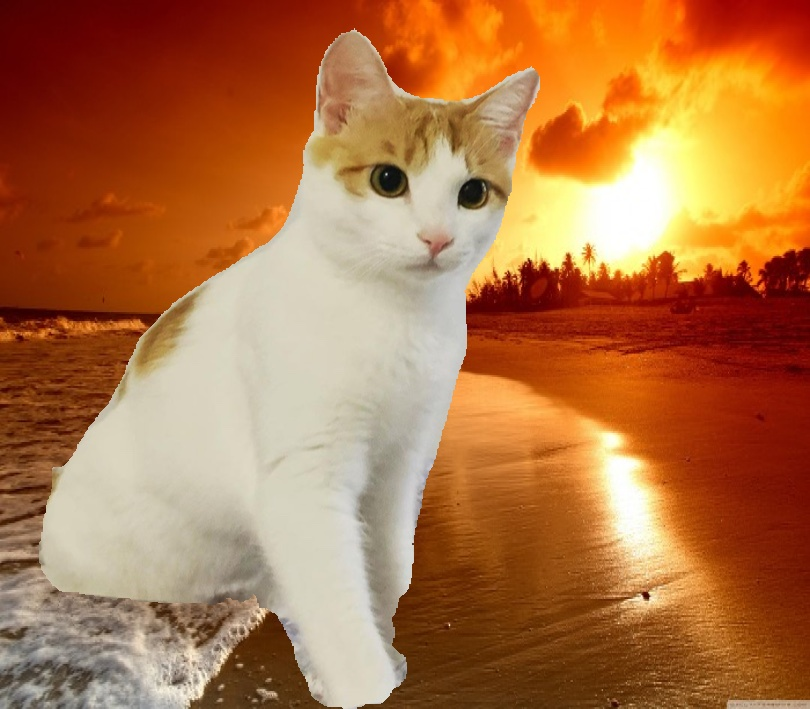

In [82]:
result_06 = os.getenv('HOME')+'/aiffel/human_segmentation/result/result06.jpg' 
Image(result_06)

## 3. 해결 방법 제안하기

> * 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안한다. 단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 한다.
> * 엔지니어로서 본인이 선택한 솔루션을 설명하고, 가능하다면 순서도(Flow Chart)를 활용하면 좋다. 

해결 방법을 제안하는 대신 관련 문제점을 해결하는 논문의 내용을 첨부한다.

### 1) 조밀한 예측을 위해 feature-map이 줄어드는 문제 해결

sementicsegmentation은 픽셀 단위의 조밀한 예측이 필요한데, classification 망을 기반으로 segmentation 망을 구성하게 되면 계속 feature-map의 크기가 줄어들기 때문에 dtail 정보를 얻는데 어려움이 있다. 그래서 FCN 개발자는 skip layer를 사용하여 1/8, 1/16, 1/32 결과를 결합하여 detail이 줄어드는 문제를 보강하였다.
또한 dilated convoulution 혹은 astrous convolution을 사용하여 receptive field를 확장시키는 효과를 얻었고, 1/8 크기까지만 줄이는 방법을 사용하여 detail이 사라지는 것을 보완하였다. 

*astrous convolution은 학습해야 하는 parameter의 수는 고정을 하고, receptive field의 크기만 늘어나는 convolution 연산이다.

### 2) DCNN의 spatial accuracy 문제 해결

이미지를 줄였다가 다시 늘리는 방식으로 인해, 정확한 위치에 이미지를 인식하지 못하는것이 문제가 된다. 그래서 논문에서는 fully connected CRF(Conditional Random Field)라는 후처리 방법을 통해서 문제를 해결한다.

### 3) 서로 다른 object 크기인 물체 인식 문제 해결

object detection에서의 문제와 비슷해 보이지만, object detection은 boundary box를 정확히 취하는 것이고, segmentation에서는 같은 물체를 색칠하는 것을 목표로 한다.
이 논문에서는 ASPP(Astrous Spatial Pyramid Pooling)이라는 방법으로 이 multi-scale문제를 해결한다.여기서도 astrous conv를 사용하는데, 특정레이어다 여러개의 astrous convolution을 처리하는 분기를 만들고 이를 다시 취합하는 방식을 따른다.

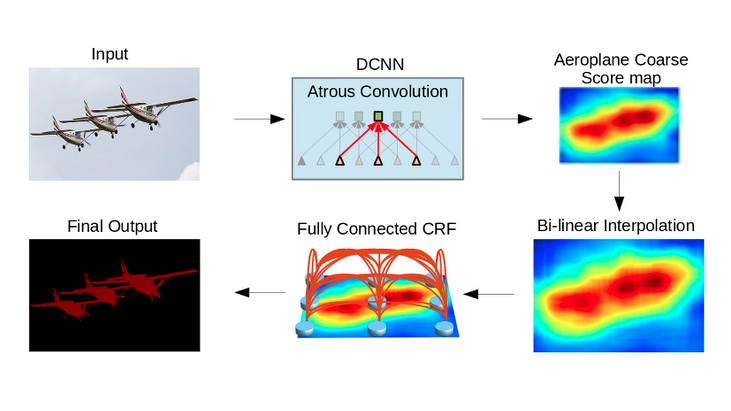

In [85]:
flow = os.getenv('HOME')+'/aiffel/human_segmentation/flow_chart.png' 
Image(flow)

논문 : https://arxiv.org/pdf/1606.00915.pdf

출처: https://dogfoottech.tistory.com/169 [SweetzLab 기술블로그]

## 결과

> 대체적으로 이미지와 배경의 조밀한 예측이 부족했고, 이로 인해 배경의 일부 또는 이미지의 일부를 인식하지 못했다. 추가적으로 블러 처리한 배경이 흰색과 가깝고 단조로울 경우, 이미지와 배경의 경계가(회색 외곽선) 도드라져 보인다. 뒷 배경의 색감이 다양하고 화려할 수록 외곽선은 희미해지는 효과가 있다. 

## 총평

> 생각보다 지정한 라벨대로 사물 인식을 잘해서 신기했다. 구글에서 제공하는 PASCAL VOC의 라벨은 20(background 제외)개로 이루어졌지만, 더 많은 라벨이 학습된다면 다양한 segmentation이 가능할 것이다. 